# SD212: Graph mining
## Lab 7: Graph embedding

In this lab, you will learn to embed the nodes of a graph in a vector space of low dimension.

## Import

In [14]:
from IPython.display import SVG

In [15]:
import numpy as np
from scipy import sparse

In [16]:
# if you get any error, please update scikit-network!
from sknetwork.data import load_netset, karate_club, house
from sknetwork.clustering import KMeans
from sknetwork.embedding import Spectral, BiSpectral
from sknetwork.ranking import PageRank, BiPageRank, top_k
from sknetwork.visualization import svg_graph, svg_digraph

## Data

We will work on the following graphs (see the [NetSets](https://graphs.telecom-paristech.fr/Home_page.html#netsets-section) collection for details):
* Openflights (graph)
* WikiVitals (digraph)
* Cinema (bigraph)

In [17]:
openflights = load_netset('openflights')
wikivitals = load_netset('wikivitals')
cinema = load_netset('cinema')

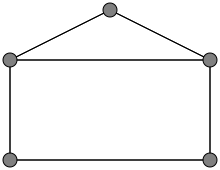

In [8]:
graph = house(metadata=True)
adjacency = graph.adjacency
position = graph.position
image = svg_graph(adjacency, position, scale=0.5)
SVG(image)

In [10]:
spectral = Spectral(1, barycenter=False, normalized=False, regularization=None)
embedding = spectral.fit_transform(adjacency)
emb = np.c_[embedding, np.zeros(embedding.shape[0])]
labels = np.array([embedding[i,0]>0 for i in range(adjacency.shape[0])])

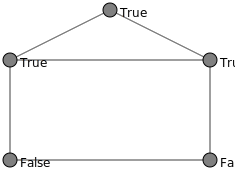

In [13]:
image = svg_graph(adjacency, position, labels, scale=0.5)
SVG(image)

## 1. Graphs

## Karate Club


We first consider the spectral embedding of the [karate club graph](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

In [199]:
graph = karate_club(True)

In [200]:
adjacency = graph.adjacency
position = graph.position
labels_true = graph.labels

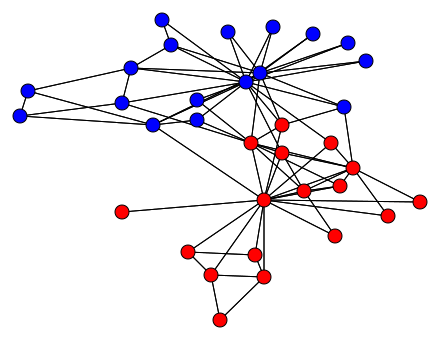

In [201]:
image = svg_graph(adjacency, position, labels=labels_true)
SVG(image)

## To do

* Display the spectrum of the normalized Laplacian (e.g., first 20 eigenvalues). 
* What does the spectrum suggest?
* Display the graph with the embedding in dimension 2.
* Check that the embedding weighted by the degrees is centered.
* How many nodes are misclassified using the sign of the first eigenvector? What are these nodes?

In [218]:
spectral = Spectral(20, barycenter=False, normalized=False, regularization=None)

In [219]:
spectral.fit(adjacency)

Spectral(n_components=20, normalized_laplacian=True, regularization=None, relative_regularization=True, equalize=False, barycenter=False, normalized=False, solver=LanczosEig(which='LA', maxiter=None, tol=0.0))

In [220]:
eigenvalues = spectral.eigenvalues_

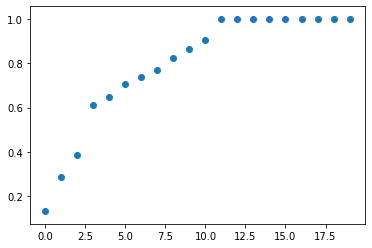

In [221]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(20), eigenvalues)
plt.show()

**On voit qu'on a plusieurs fois la valeur propre égale à 1. On peut donc supposer que la dimensionalité peut encore être réduite.**

**Car 1 - eigenvalues = eigenvalues of P (transition matrix)
Du coup, #(eigenvalue != 1) = rank(P)**

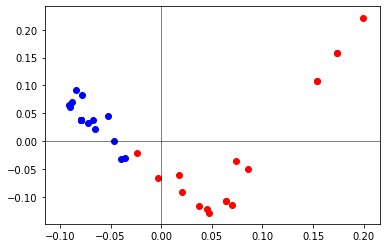

In [222]:
COLORS = ['blue', 'red']
plt.axvline(0, linewidth=0.5, c='k')
plt.axhline(0, linewidth=0.5, c='k')

for l in np.unique(labels_true):
    nodes = np.argwhere(labels_true == l).ravel()
    plt.scatter(embedding[nodes,0], embedding[nodes,1], color=COLORS[l])

Misclassified nodes:  17


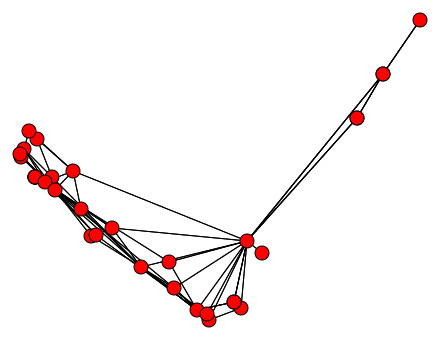

In [223]:
spectral = Spectral(2, barycenter=False, normalized=False, regularization=None)
embedding = spectral.fit_transform(adjacency)
eigenvalues = spectral.eigenvalues_
labels = np.array([eigenvalues[0]>0 for i in range(labels_true.shape[0])])
print("Misclassified nodes: ", np.argwhere(labels_true!= labels).shape[0])
image = svg_graph(adjacency, embedding, labels=labels)
SVG(image)

In [224]:
degrees = adjacency @ np.ones(adjacency.shape[0])
np.mean(sparse.diags(degrees)@embedding, axis=0) 

array([-1.76329539e-16,  1.76329539e-16])

Misclassified nodes:  2
[[2]
 [8]]


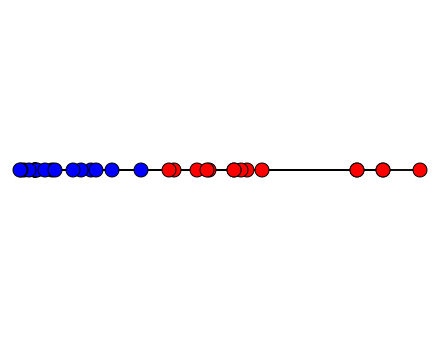

In [102]:
spectral = Spectral(1, barycenter=False, normalized=False, regularization=None)
embedding = spectral.fit_transform(adjacency)
emb = np.c_[embedding, np.zeros(embedding.shape[0])]
labels = np.array([embedding[i,0]>0 for i in range(labels_true.shape[0])])

print("Misclassified nodes: ", np.argwhere(labels_true!= labels).shape[0])
print(np.argwhere(labels_true!= labels))
image = svg_graph(adjacency, emb, labels=labels)
SVG(image)

## Openflights


We now consider a larger graph. We use the Laplacian eigenmap in dimension 20. We measure proximity between nodes in terms of [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Equivalently, we work on the embedding in the unit sphere, which can be obtained through the parameter ``normalized`` of the class ``Spectral``.

In [38]:
graph = openflights

In [39]:
adjacency = graph.adjacency
position = graph.position
names = graph.names

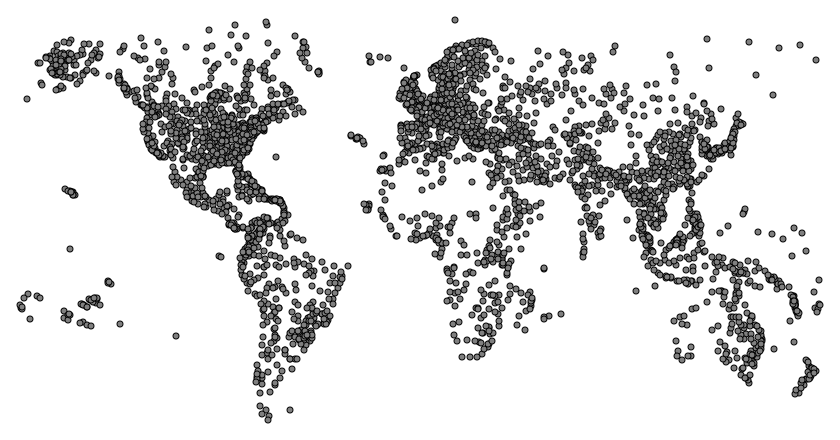

In [40]:
image = svg_graph(adjacency, position, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## To do

* Display the spectrum of the normalized Laplacian.
* Display the same world map with the scores equal to the cosine similarity to **Beijing** in the embedding space.
* List the 10 closest airports to **Madrid** in terms of cosine similarity in the embedding space.
* Display the same world map with the 10 clusters found by k-means in the embedding space.<br> **Hint:** Use the class ``KMeans`` with the appropriate embedding.

In [41]:
spectral = Spectral(20)
embedding = spectral.fit_transform(adjacency)
eigenvalues = spectral.eigenvalues_
print(eigenvalues)

[0.04263086 0.06631577 0.07644682 0.08199739 0.08938849 0.09423468
 0.11092704 0.12204439 0.12778802 0.13659393 0.1568031  0.16346447
 0.17905771 0.19084087 0.20666723 0.22688182 0.27197016 0.31758522
 0.32271519 0.35440907]


In [42]:
from numpy import linalg as LA

def cos_sim(a,b):
    return a@b.T/(LA.norm(a)*LA.norm(b))

In [43]:
beijing = 1618

In [44]:
# Proposition
list_sim = []
for i in range(embedding.shape[0]):
    sim = cos_sim(embedding[i],embedding[beijing])
    list_sim.append(sim)
list_sim = np.array(list_sim)

In [45]:
# Correction 
scores = embedding @ embedding[beijing] 

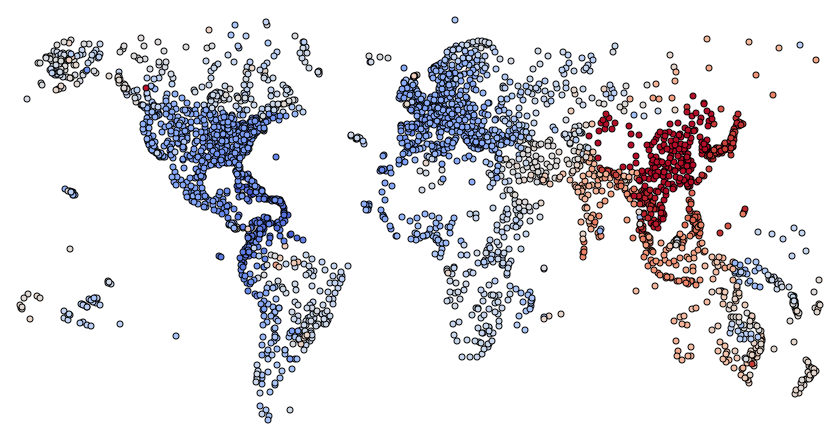

In [46]:
image = svg_graph(adjacency, position, scores=scores, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

In [47]:
madrid = 572

In [48]:
# Proposition
list_sim = []
for i in range(embedding.shape[0]):
    sim = cos_sim(embedding[i],embedding[madrid])
    list_sim.append(sim)
list_sim = np.array(list_sim)
names[top_k(list_sim,10)]

array(['Adolfo Suárez Madrid–Barajas Airport', 'Pamplona Airport',
       'Tenerife Norte Airport', 'Logroño-Agoncillo Airport',
       'San Sebastian Airport', 'Badajoz Airport', 'La Gomera Airport',
       'A Coruña Airport', 'Amsterdam Airport Schiphol',
       'London Gatwick Airport'], dtype='<U65')

In [49]:
paris = 622

In [50]:
# Correction
scores = embedding @ embedding[paris] 
names[top_k(scores,10)]

array(['Charles de Gaulle International Airport',
       'Nouakchott International Airport', 'Ouarzazate Airport',
       'Banjul International Airport', 'Nouadhibou International Airport',
       'Tazadit Airport', 'Sfax Thyna International Airport',
       'Mohammed V International Airport', 'Annaba Airport',
       'Frankfurt am Main International Airport'], dtype='<U65')

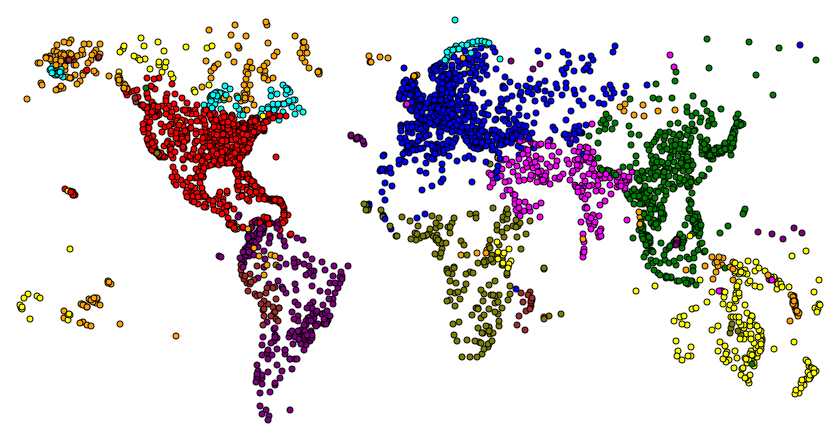

In [243]:
kmeans = KMeans(10, embedding_method=Spectral(20, normalized=True))
labels = kmeans.fit_transform(adjacency)
image = svg_graph(adjacency, position, labels=labels, width=800, height=400, node_size=3, display_edges=False)
SVG(image)

## 2. Digraphs

## Wikipedia Vitals

We now consider a large directed graph. We use the class ``BiSpectral`` (i.e., the directed graph is viewed as a bipartite graph).

In [303]:
graph = wikivitals

In [304]:
adjacency = graph.adjacency
names = graph.names
labels = graph.labels_hierarchy
names_labels = graph.names_labels_hierarchy

## To do

* Check that the average cosine similarity between nodes in some set $S$ is given by the square norm of the barycenter of $S$.
* Give the average cosine similarity between nodes in the **Mammals** category.
* Compare with the expected cosine similarity between two nodes sampled uniformly at random.
* Give the average cosine similarity between nodes in some category of your choice.

In [305]:
spectral = BiSpectral(20)

In [306]:
embedding = spectral.fit_transform(adjacency)
nb_s = 100
list_sim = []
for i in range(nb_s):
    for j in range(nb_s):
        sim = cos_sim(embedding[i],embedding[j])
        list_sim.append(sim)
list_sim = np.array(list_sim)

In [307]:
avg_cos_sim = np.mean(list_sim)
barycenter = np.mean(embedding[:nb_s],axis=0)
norm_bar = LA.norm(barycenter)**2
print(avg_cos_sim)
print(norm_bar)

0.30314898235169435
0.30314898235169424


In [308]:
mammal = 274

In [309]:
names_labels[mammal]

'Biology and health sciences.Organisms.Animals.Mammals'

In [310]:
nodes = np.where(labels == mammal)[0]
LA.norm(np.mean(embedding[nodes], axis=0))**2

0.8867632428676835

In [311]:
LA.norm(np.mean(embedding, axis = 0))**2

0.013350043058728306

In [312]:
europe = np.argwhere(names_labels=='Geography.Cities.Europe.Northern Europe')[0,0]

In [313]:
nodes = np.where(labels == europe)[0]
LA.norm(np.mean(embedding[nodes], axis=0))**2

0.9497048259175496

## 3. Bigraphs

## Cinema

Finally, we consider the co-embedding of a large bipartite graph. We use the Laplacian eigenmap in dimension 20.

In [326]:
graph = cinema

In [327]:
biadjacency = graph.biadjacency
movies = graph.names_row
actors = graph.names_col

## To do

* What is the cosine similarity between **Marion Cotillard** and **The Godfather**  in the embedding space?
* What is the cosine similarity between **The Godfather** and **The Godfather 2** in the embedding space?

In [328]:
bispectral = BiSpectral(20, regularization=0.1)

In [329]:
cotillard = 3814

In [330]:
actors[cotillard]

'Marion Cotillard'

In [331]:
godfather = 69768
godfather2 = 69770

In [332]:
movies[godfather]

'The Godfather'

In [333]:
movies[godfather2]

'The Godfather Part II'

In [336]:
bispectral.fit(biadjacency)
embedding_row = bispectral.embedding_row_
embedding_col = bispectral.embedding_col_

In [338]:
embedding_row[godfather] @ embedding_col[cotillard] 

0.6856126504997226

In [341]:
embedding_row[godfather] @ embedding_row[godfather2] 

0.9717431640927072